<a href="https://colab.research.google.com/github/Prabhu-2004-04/Web-App-Dev/blob/main/clothingipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Setup ---
!pip install mediapipe
!pip install torch torchvision
!pip install requests
!pip install tqdm

import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
from io import BytesIO
from PIL import Image, UnidentifiedImageError

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load pose detector ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

# --- Utility functions ---

def load_image_from_url(url, size=(128,128)):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize(size)
        return np.array(img)
    except UnidentifiedImageError:
        print(f"Error: Could not identify image file from URL: {url}")
        return None
    except Exception as e:
        print(f"An error occurred while loading image from {url}: {e}")
        return None


def get_pose_heatmap(image):
    # Convert to RGB for MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)
    heatmap = np.zeros(image.shape[:2], dtype=np.uint8)
    h, w = image.shape[:2]
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            # Check if landmark coordinates are within bounds before drawing
            cx, cy = int(lm.x * w), int(lm.y * h)
            if 0 <= cx < w and 0 <= cy < h:
                cv2.circle(heatmap, (cx, cy), 5, 255, thickness=-1)
    heatmap = cv2.resize(heatmap, (128, 128))
    return heatmap


transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_pose = transforms.Compose([
    transforms.ToTensor(),
])

# --- Simple Generator ---
class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )
    def forward(self, x):
        e = self.encoder(x)
        d = self.decoder(e)
        return d

G = SimpleGenerator().to(device)

# --- Load sample data (3 body poses, 3 clothes) ---

# Sample person pose images URLs (you can replace by webcam capture images)
person_urls = [
    "https://i.imgur.com/3v0fYPL.jpg",  # person1
    "https://i.imgur.com/Vz6uC5H.jpg",  # person2
    "https://i.imgur.com/r5CNJus.jpg"   # person3
]

# Sample clothing images URLs (clean cloth images)
cloth_urls = [
    "https://i.imgur.com/Yl7WZpq.png",  # cloth1
    "https://i.imgur.com/7eWwTfG.png",  # cloth2
    "https://i.imgur.com/gYZlQqD.png"   # cloth3
]

person_images = []
pose_maps = []
cloth_images = []

print("Loading person images and generating pose maps...")
for url in tqdm(person_urls, desc="Loading person images"):
    img = load_image_from_url(url)
    if img is not None:
        person_images.append(img)
        heatmap = get_pose_heatmap(img)
        pose_maps.append(heatmap)
    else:
        print(f"Skipping pose estimation for URL: {url}")


print("Loading cloth images...")
for url in tqdm(cloth_urls, desc="Loading cloth images"):
    cloth_img = load_image_from_url(url)
    if cloth_img is not None:
        cloth_images.append(cloth_img)
    else:
         print(f"Skipping cloth image for URL: {url}")


# --- Preprocess function ---
def preprocess(person_img, pose_map, cloth_img):
    person_t = transform_img(person_img)
    pose_t = transform_pose(pose_map)
    cloth_t = transform_img(cloth_img)
    input_tensor = torch.cat([pose_t, cloth_t], dim=0)  # 1 pose + 3 cloth = 4 channels
    return person_t.unsqueeze(0).to(device), input_tensor.unsqueeze(0).to(device)

# --- Training setup ---
criterion = nn.MSELoss()
optimizer = optim.Adam(G.parameters(), lr=0.0002)

# --- Dummy target: let's pretend the target image is the person image (demo purpose) ---
epochs = 10
batch_size = 1

if len(person_images) == 0 or len(cloth_images) == 0:
    print("Not enough valid images loaded to start training.")
else:
    print("Starting dummy training on small dataset...")
    for epoch in range(epochs):
        total_loss = 0
        # Ensure we don't go out of bounds for person images if some failed to load
        num_samples = min(len(person_images), len(cloth_images))
        if num_samples == 0:
            print("No valid image pairs to train on. Exiting training loop.")
            break

        for i in range(num_samples):
            # Cycle through clothes to simulate different cloth on body
            cloth_img = cloth_images[i % len(cloth_images)]

            target, input_tensor = preprocess(person_images[i], pose_maps[i], cloth_img)

            optimizer.zero_grad()
            output = G(input_tensor)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} Loss: {total_loss/num_samples:.4f}")

    # --- Generate and show results for each pair ---
    G.eval()
    print("Generating and showing results...")
    num_results = min(len(person_images), len(cloth_images))
    if num_results == 0:
        print("No valid image pairs to generate results for.")
    else:
        for i in range(num_results):
            cloth_img = cloth_images[i % len(cloth_images)]
            _, input_tensor = preprocess(person_images[i], pose_maps[i], cloth_img)
            with torch.no_grad():
                out = G(input_tensor).cpu()[0]
            out_img = out * 0.5 + 0.5
            out_img = out_img.permute(1,2,0).numpy()
            out_img = (out_img * 255).astype(np.uint8)
            plt.figure(figsize=(4,4))
            plt.title(f"Body {i+1} + Cloth {i%len(cloth_images)+1}")
            plt.axis('off')
            plt.imshow(out_img)
            plt.show()

print("Demo finished.")

Loading person images and generating pose maps...


Loading person images: 100%|██████████| 3/3 [00:00<00:00, 16.45it/s]


Error: Could not identify image file from URL: https://i.imgur.com/3v0fYPL.jpg
Skipping pose estimation for URL: https://i.imgur.com/3v0fYPL.jpg
Error: Could not identify image file from URL: https://i.imgur.com/Vz6uC5H.jpg
Skipping pose estimation for URL: https://i.imgur.com/Vz6uC5H.jpg
Error: Could not identify image file from URL: https://i.imgur.com/r5CNJus.jpg
Skipping pose estimation for URL: https://i.imgur.com/r5CNJus.jpg
Loading cloth images...


Loading cloth images:   0%|          | 0/3 [00:00<?, ?it/s]

Error: Could not identify image file from URL: https://i.imgur.com/Yl7WZpq.png
Skipping cloth image for URL: https://i.imgur.com/Yl7WZpq.png


Loading cloth images: 100%|██████████| 3/3 [00:00<00:00, 19.23it/s]

Error: Could not identify image file from URL: https://i.imgur.com/7eWwTfG.png
Skipping cloth image for URL: https://i.imgur.com/7eWwTfG.png
Error: Could not identify image file from URL: https://i.imgur.com/gYZlQqD.png
Skipping cloth image for URL: https://i.imgur.com/gYZlQqD.png
Not enough valid images loaded to start training.
Demo finished.


Please capture your image:


<IPython.core.display.Javascript object>

Image saved as photo.jpg


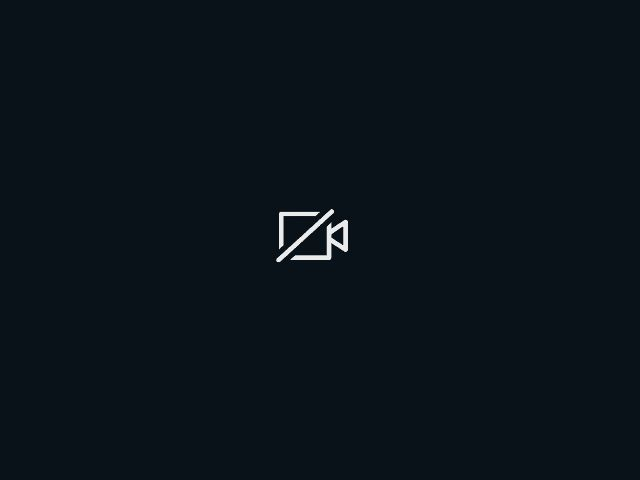

Pose landmarks detected and drawn:


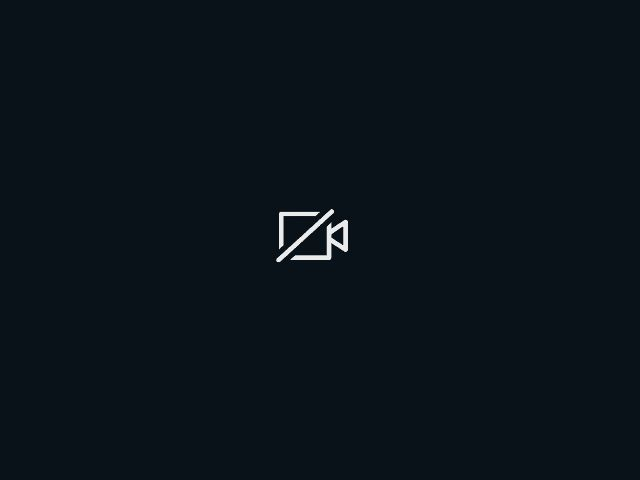

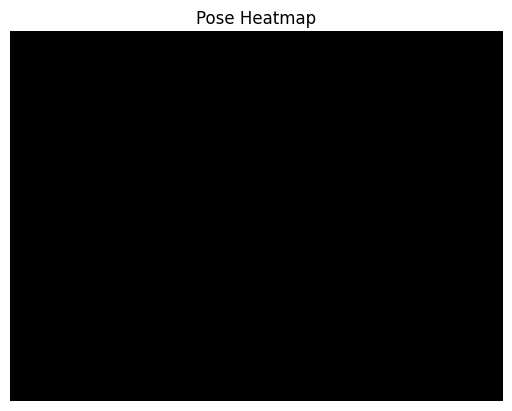

Input tensor shape: torch.Size([1, 4, 128, 128])
Starting dummy training for 5 epochs...
Epoch 1 Loss: 0.8115
Epoch 2 Loss: 0.6823
Epoch 3 Loss: 0.5871
Epoch 4 Loss: 0.5165
Epoch 5 Loss: 0.4630


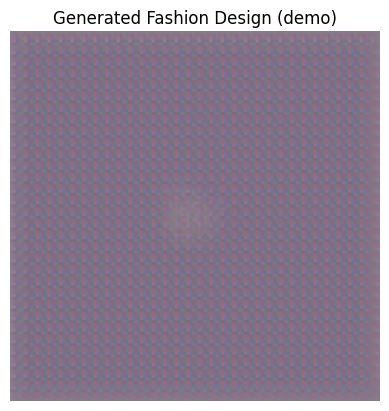

For real training, prepare dataset with person images, pose maps, and target fashion design images.
You can use public datasets like DeepFashion or MPV.
Upload your dataset to Colab and build a DataLoader for training.


In [ ]:
# --- 1. Setup: Install dependencies ---
!pip install mediapipe
!pip install torch torchvision
!pip install tqdm

import cv2
import mediapipe as mp
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow

# --- 2. Webcam capture function ---
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      const button = document.createElement('button');
      button.textContent = 'Capture';
      div.appendChild(video);
      div.appendChild(button);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => button.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js(f'takePhoto({quality})')
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Capture photo
print("Please capture your image:")
user_img_path = take_photo()
print(f"Image saved as {user_img_path}")

# Show captured image
user_img = cv2.imread(user_img_path)
cv2_imshow(user_img)

# --- 3. Pose estimation with MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
image_rgb = cv2.cvtColor(user_img, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)

# Draw pose landmarks
annotated_img = user_img.copy()
mp_drawing = mp.solutions.drawing_utils
mp_drawing.draw_landmarks(annotated_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

print("Pose landmarks detected and drawn:")
cv2_imshow(annotated_img)

# --- 4. Prepare pose heatmap for conditioning ---

def create_pose_heatmap(image_shape, landmarks, radius=5):
    heatmap = np.zeros(image_shape[:2], dtype=np.uint8)
    h, w = image_shape[:2]
    if landmarks is None:
        return heatmap
    for lm in landmarks.landmark:
        cx, cy = int(lm.x * w), int(lm.y * h)
        cv2.circle(heatmap, (cx, cy), radius, (255), thickness=-1)
    return heatmap

pose_heatmap = create_pose_heatmap(user_img.shape, results.pose_landmarks)
plt.imshow(pose_heatmap, cmap='gray')
plt.title("Pose Heatmap")
plt.axis('off')
plt.show()

# --- 5. Simple Generator Model (cGAN style) ---

class SimpleGenerator(nn.Module):
    def __init__(self):
        super(SimpleGenerator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1),  # 3 channels person img + 1 pose heatmap
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        e = self.encoder(x)
        d = self.decoder(e)
        return d

# --- 6. Preprocessing and transforms ---

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def preprocess_input(person_img, pose_map):
    person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)
    person_tensor = transform(person_img)  # 3 x 128 x128
    pose_map = cv2.resize(pose_map, (128,128))
    pose_map = torch.tensor(pose_map/255., dtype=torch.float32).unsqueeze(0)  # 1 x 128 x128
    input_tensor = torch.cat([person_tensor, pose_map], dim=0).unsqueeze(0)  # 1 x 4 x 128 x128
    return input_tensor

input_tensor = preprocess_input(user_img, pose_heatmap)
print(f"Input tensor shape: {input_tensor.shape}")

# --- 7. Instantiate Generator ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = SimpleGenerator().to(device)
G.train()

# --- 8. Dummy Training Loop (illustration only) ---

optimizer = optim.Adam(G.parameters(), lr=0.0002)
criterion = nn.MSELoss()

# For demo, target = input person image normalized (just to show training)
target_tensor = input_tensor[:, :3, :, :].to(device)  # use person image channels as "target"

print("Starting dummy training for 5 epochs...")
for epoch in range(5):
    optimizer.zero_grad()
    output = G(input_tensor.to(device))
    loss = criterion(output, target_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

# --- 9. Generate output image ---

G.eval()
with torch.no_grad():
    output_img = G(input_tensor.to(device))[0].cpu()
    output_img = output_img * 0.5 + 0.5  # denormalize to [0,1]
    output_img = output_img.permute(1,2,0).numpy()
    output_img = (output_img * 255).astype(np.uint8)

plt.imshow(output_img)
plt.title("Generated Fashion Design (demo)")
plt.axis('off')
plt.show()

# --- 10. Dataset (Optional) ---

print("For real training, prepare dataset with person images, pose maps, and target fashion design images.")
print("You can use public datasets like DeepFashion or MPV.")
print("Upload your dataset to Colab and build a DataLoader for training.")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class FashionTryOnDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.person_dir = os.path.join(root_dir, 'person_images')
        self.pose_dir = os.path.join(root_dir, 'pose_maps')
        self.cloth_dir = os.path.join(root_dir, 'clothing_images')
        self.target_dir = os.path.join(root_dir, 'target_images')
        self.transform = transform

        self.file_names = os.listdir(self.person_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        fname = self.file_names[idx]

        person_img = Image.open(os.path.join(self.person_dir, fname)).convert('RGB')
        pose_map = Image.open(os.path.join(self.pose_dir, fname)).convert('L')  # grayscale heatmap
        cloth_img = Image.open(os.path.join(self.cloth_dir, fname)).convert('RGB')
        target_img = Image.open(os.path.join(self.target_dir, fname)).convert('RGB')

        if self.transform:
            person_img = self.transform(person_img)
            pose_map = self.transform(pose_map)
            cloth_img = self.transform(cloth_img)
            target_img = self.transform(target_img)

        # Concatenate pose + cloth for conditioning
        cond = torch.cat([pose_map, cloth_img], dim=0)  # (1 + 3) channels

        return person_img, cond, target_img


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = FashionTryOnDataset('/content/photo.jpg', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


NotADirectoryError: [Errno 20] Not a directory: '/content/photo.jpg/person_images'